In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import DenseNet121
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
train_dir = "../input/train/train/"
test_dir = "../input/test/test/"
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


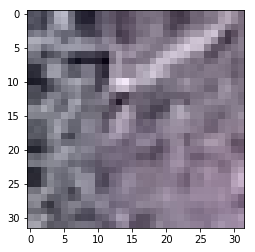

In [3]:
im = cv2.imread("../input/train/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg")
plt.imshow(im)

In [4]:
DenseNet121_net = DenseNet121(weights='imagenet', 
                  include_top=False, 
                  input_shape=(32, 32, 3))

29089792/29084464 [==============================] - 1s 0us/step


In [5]:
DenseNet121_net.trainable = False
DenseNet121_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [6]:
model = Sequential()
model.add(DenseNet121_net)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

In [8]:
X_tr = []
Y_tr = []
imges = train_df['id'].values
for img_id in tqdm_notebook(imges):
    X_tr.append(cv2.imread(train_dir + img_id))    
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)

In [9]:
batch_size = 32
nb_epoch = 500

In [10]:
%%time
# Train model
history = model.fit(X_tr, Y_tr,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)

Train on 15750 samples, validate on 1750 samples
Epoch 1/500
 - 18s - loss: 0.6537 - acc: 0.7088 - val_loss: 0.4405 - val_acc: 0.7743
Epoch 2/500
 - 10s - loss: 0.5014 - acc: 0.7698 - val_loss: 0.3984 - val_acc: 0.8343
Epoch 3/500
 - 10s - loss: 0.4205 - acc: 0.8100 - val_loss: 0.3824 - val_acc: 0.8686
Epoch 4/500
 - 10s - loss: 0.3722 - acc: 0.8309 - val_loss: 0.3661 - val_acc: 0.8771
Epoch 5/500
 - 10s - loss: 0.3427 - acc: 0.8474 - val_loss: 0.3653 - val_acc: 0.8720
Epoch 6/500
 - 10s - loss: 0.3114 - acc: 0.8630 - val_loss: 0.3543 - val_acc: 0.8709
Epoch 7/500
 - 10s - loss: 0.2980 - acc: 0.8728 - val_loss: 0.3572 - val_acc: 0.8606
Epoch 8/500
 - 10s - loss: 0.2771 - acc: 0.8811 - val_loss: 0.3825 - val_acc: 0.8371
Epoch 9/500
 - 10s - loss: 0.2666 - acc: 0.8877 - val_loss: 0.3720 - val_acc: 0.8411
Epoch 10/500
 - 10s - loss: 0.2598 - acc: 0.8920 - val_loss: 0.3887 - val_acc: 0.8223
Epoch 11/500
 - 10s - loss: 0.2448 - acc: 0.8994 - val_loss: 0.3859 - val_acc: 0.8251
Epoch 12/500
 

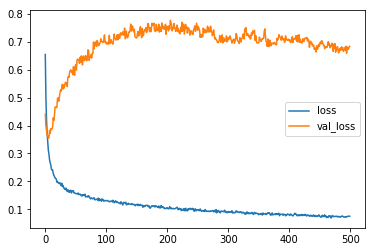

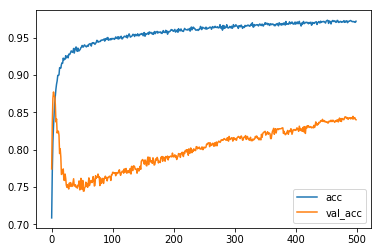

In [11]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [12]:
%%time
X_tst = []
Test_imgs = []
for img_id in tqdm_notebook(os.listdir(test_dir)):
    X_tst.append(cv2.imread(test_dir + img_id))     
    Test_imgs.append(img_id)
X_tst = np.asarray(X_tst)
X_tst = X_tst.astype('float32')
X_tst /= 255


CPU times: user 664 ms, sys: 432 ms, total: 1.1 s
Wall time: 5.77 s


In [13]:
# Prediction
test_predictions = model.predict(X_tst)

In [14]:
sub_df = pd.DataFrame(test_predictions, columns=['has_cactus'])
sub_df['has_cactus'] = sub_df['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

In [15]:
sub_df['id'] = ''
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]

In [16]:
for i, img in enumerate(Test_imgs):
    sub_df.set_value(i,'id',img)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [17]:
sub_df.head()

,id,has_cactus
0,79ac4cc3b082e0a1defe1be601806efd.jpg,1
1,e880364d6521c6f3a27748ec62b0e335.jpg,1
2,74912492b6cdf28c4bfb9c8e1d35af3e.jpg,1
3,078cfa961183b30693ea2f13f5ff6d17.jpg,1
4,7fd729184ef182899ce3e7a174fb9bc0.jpg,1


In [18]:
sub_df.to_csv('submission.csv',index=False)